In [1]:
import os
import json
import time
import folium
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
from turtle import color
from folium import plugins
import matplotlib.pyplot as plt
%matplotlib inline
from difflib import SequenceMatcher
from folium.plugins import FastMarkerCluster
pd.options.mode.chained_assignment = None  #close copy warning   

In [2]:
# calculate the similarity percentage
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

# find the most similar suburb
def most_similar(df,suburb):
    if df['suburb'].shape[0] == 1:
        current_match = [100,df['suburb'].iloc[0][0]]
    else:
        # initialize the most similar suburb
        current_match = [0,"None"]
        # check similarity for each suburb
        for sub in df['suburb']:
            # get the similarity percentage
            simi_percent = similar(suburb, sub)
            # update most similar suburb
            if simi_percent > current_match[0]:
                current_match = [simi_percent, sub]
    # return the most similar suburb
    return current_match[1]
# find the most similar suburb names for rental data
def correct_suburb(suburb_df, df):
    # check property_df each row's suburb
    for row in range(df.shape[0]):
        # all the suburb names
        sub_lis = list(set(suburb_df.suburb.sum()))
        # if the suburb matched, don't change it
        if df.loc[row, 'suburb'] in sub_lis:
            pass
        # if the suburb don't matched, replace by the most similar suburb by postcode
        else:
            most_match = most_similar(pd.DataFrame.from_dict({'suburb':sub_lis}), df.loc[row, 'suburb'])
            df.at[row, 'suburb'] = most_match
    return df

In [3]:
property_df = pd.read_csv("../data/curated/data.csv")
rent = pd.read_csv("../data/curated/predict_rent_rf.csv")
income = pd.read_csv('../data/curated/predict_income_ols.csv')
rental = pd.read_csv('../data/curated/predict_rental_AutoReg.csv')
house_price = pd.read_csv('../data/curated/predict_house_price_median.csv')
population = pd.read_csv('../data/curated/predict_population_AutoReg.csv')
affordable = pd.read_csv('../data/curated/affordable.csv')
match = pd.read_csv('../data/curated/match.csv')

#read postcode match suburb
with open('../data/raw/postcode_match_suburb.json') as json_data:
    data = json.load(json_data)
postcode_match = pd.DataFrame.from_dict({'postcode':data.keys(), 'suburb':data.values()})
postcode_match['postcode'] = pd.to_numeric(postcode_match['postcode'])

In [4]:
def get_0(lis):
    return lis[0]

def delete_space(string):
    if string[-1] == ' ':
        return string[:len(string)-1]
    else:
        return string
def replace_word(string):
    string = string.replace(' (SOUTH)','')
    string = string.replace(' (NORTH)','')
    string = string.replace(' (VICNP)','')
    string = string.replace(' (WEST)','')
    string = string.replace('ST KILDA EAST','ST KILDA')
    string = string.replace(' (EAST)','')
    string = string.replace(' INDUSTRIAL','')
    string = string.replace('MELBOURNE CBD','MELBOURNE')
    string = string.replace(' INDUSTRIAL','')
    string = string.replace(' (VIC.)','')
    string = string.replace('  ','')
    return string
 


income['SA2_name'] = income['SA2_name'].str.split("-")
income['suburb'] = income['SA2_name'].apply(get_0)
income['suburb'] = income['suburb'].str.upper()
income['suburb'] = income['suburb'].apply(replace_word)
income['suburb'] = income['suburb'].apply(delete_space)
income = correct_suburb(postcode_match,income)
income = income.groupby('suburb').agg('sum').reset_index()


population['SA2_name'] = population['SA2_name'].str.split("-")
population['suburb'] = population['SA2_name'].apply(get_0)
population['suburb'] = population['suburb'].str.upper()
population['suburb'] = population['suburb'].apply(replace_word)
population['suburb'] = population['suburb'].apply(delete_space)
population = correct_suburb(postcode_match,population)
population = population.groupby('suburb').agg('sum').reset_index()

affordable = affordable[['LGA','Percent_total_Sep_2000', 'Percent_total_Sep_2001', 'Percent_total_Sep_2002', 'Percent_total_Sep_2003', 'Percent_total_Sep_2004', 'Percent_total_Sep_2005', 'Percent_total_Sep_2006', 'Percent_total_Sep_2007', 'Percent_total_Sep_2008', 'Percent_total_Sep_2009', 'Percent_total_Sep_2010', 'Percent_total_Sep_2011', 'Percent_total_Sep_2012', 'Percent_total_Sep_2013', 'Percent_total_Sep_2014', 'Percent_total_Sep_2015', 'Percent_total_Sep_2016', 'Percent_total_Sep_2017', 'Percent_total_Sep_2018', 'Percent_total_Sep_2019', 'Percent_total_Sep_2020', 'Percent_total_Sep_2021']]

In [5]:
display(income.head(2))
display(population.head(2))
display(affordable.head(5))

,suburb,2014-15_median_income,2015-16_median_income,2016-17_median_income,2017-18_median_income,2018-19_median_income,2019-20_median_income,2020-21_median_income,2021-22_median_income,2022-23_median_income,2023-24_median_income,2024-25_median_income,2025-26_median_income,2026-27_median_income,2027-28_median_income,SA2_Code
0,ABBOTSFORD,53987.0,57501.0,58359.0,61476.0,64090.0,66336.9,68755.0,71173.1,73591.2,76009.3,78427.4,80845.5,83263.6,85681.7,206071139
1,AIRPORT WEST,50094.0,52329.0,53575.0,55912.0,58506.0,60205.3,62246.0,64286.7,66327.4,68368.1,70408.8,72449.5,74490.2,76530.9,210011226


,suburb,2001_population,2002_population,2003_population,2004_population,2005_population,2006_population,2007_population,2008_population,2009_population,...,2019_population,2020_population,2021_population,2022_population,2023_population,2024_population,2025_population,2026_population,2027_population,SA2_Code
0,ABBOTSFORD,4150.0,4339.0,4444.0,4452.0,4498.0,4537.0,4638.0,4727.0,4833.0,...,9586.0,9662.0,9262.0,8566.128748,8229.589928,9427.230398,9115.747171,9785.831247,9443.453266,206071139.0
1,AIRPORT WEST,6997.0,6970.0,6952.0,6904.0,6870.0,6878.0,6920.0,6983.0,7067.0,...,8380.0,8349.0,8237.0,8368.504820,7491.265327,8189.239663,7719.931848,8827.679069,8261.738283,210011226.0


,LGA,Percent_total_Sep_2000,Percent_total_Sep_2001,Percent_total_Sep_2002,Percent_total_Sep_2003,Percent_total_Sep_2004,Percent_total_Sep_2005,Percent_total_Sep_2006,Percent_total_Sep_2007,Percent_total_Sep_2008,...,Percent_total_Sep_2012,Percent_total_Sep_2013,Percent_total_Sep_2014,Percent_total_Sep_2015,Percent_total_Sep_2016,Percent_total_Sep_2017,Percent_total_Sep_2018,Percent_total_Sep_2019,Percent_total_Sep_2020,Percent_total_Sep_2021
0,Alpine,0.848,1.000,0.952,0.985,0.929,0.907,0.909,0.844,0.868,...,0.825,0.772,0.846,0.709,0.784,0.608,0.535,0.444,0.480,0.284
1,Ararat,1.000,0.981,0.981,0.964,1.000,0.981,0.979,0.979,0.937,...,0.926,0.716,0.864,0.815,0.674,0.609,0.616,0.781,0.667,0.576
2,Ballarat,0.761,0.819,0.746,0.729,0.769,0.786,0.812,0.825,0.723,...,0.590,0.610,0.677,0.681,0.638,0.651,0.567,0.521,0.524,0.490
3,Banyule,0.123,0.214,0.214,0.222,0.191,0.273,0.172,0.099,0.051,...,0.042,0.043,0.041,0.045,0.038,0.024,0.025,0.025,0.024,0.046
4,Bass Coast,0.951,0.943,0.935,0.894,0.879,0.907,0.889,0.892,0.822,...,0.636,0.766,0.727,0.704,0.627,0.593,0.448,0.458,0.319,0.161


In [6]:
rent.head(5)

,suburb,current_rent_weekly,Sep_2022,Dec_2022,Mar_2023,Jun_2023,Sep_2023,Dec_2023,Mar_2024,Jun_2024,...,Sep_2025,Dec_2025,Mar_2026,Jun_2026,Sep_2026,Dec_2026,Mar_2027,Jun_2027,Sep_2027,Dec_2027
0,MELBOURNE,400,481.800000,479.500000,479.985714,480.300000,479.171429,478.385714,476.942857,482.128571,...,478.714286,478.228571,476.371429,481.971429,478.328571,477.728571,483.914286,478.014286,481.314286,482.771429
1,MELBOURNE,350,426.257143,426.514286,423.657143,426.114286,427.942857,428.128571,426.671429,427.700000,...,426.057143,429.400000,427.528571,423.642857,424.342857,425.728571,424.885714,425.971429,427.828571,427.642857
2,MELBOURNE,330,410.528571,410.154286,408.185714,408.414286,408.771429,409.528571,409.585714,408.985714,...,410.328571,411.128571,412.085714,410.342857,410.242857,411.071429,409.600000,409.271429,410.414286,408.242857
3,MELBOURNE,600,561.471429,560.542857,561.142857,559.557143,560.157143,561.400000,560.800000,558.485714,...,559.214286,560.314286,557.914286,560.300000,560.271429,560.242857,559.690683,561.471429,560.985714,558.600000
4,MELBOURNE,330,389.461905,389.442857,389.104762,392.247619,388.685714,390.642857,388.914286,389.385714,...,389.785714,390.261905,389.885714,389.861905,391.400000,390.342857,389.419048,388.214286,388.428571,390.000000


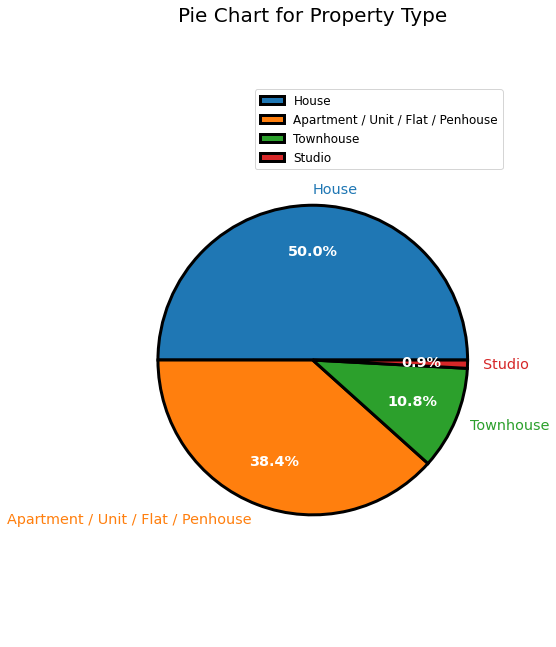

In [7]:
pie_data = property_df['type'].value_counts()
labels = pie_data.index
sizes = pie_data.values
#get label and size
fig, ax = plt.subplots(figsize = (10,9))
#draw the pie char and modify the pie chart
patches, texts, pcts = ax.pie(pie_data ,explode=None,autopct='%1.1f%%',
                               pctdistance = 0.7, labels=labels,wedgeprops={'linewidth': 3.0, 'edgecolor': 'black'},
                               textprops={'size': 'x-large'})

plt.setp(pcts, color='white', fontweight='bold')  #label color
# face color.
for i, patch in enumerate(patches):
    texts[i].set_color(patch.get_facecolor())
plt.legend(labels,prop={'size': 12},bbox_to_anchor=(1.0, 1.0))
plt.title("Pie Chart for Property Type", x=0.5, y=1.1,fontsize=20)
plt.axis('equal')
plt.tight_layout()
plt.show()

fig.figure.savefig('../plots/type_pie.png')

In [8]:
property_df['counts'] = 1

In [9]:
count_number = property_df.groupby('suburb').agg('count')[['counts']].reset_index()
count_number

,suburb,counts
0,ABBOTSFORD,40
1,ABERFELDIE,11
2,ADAMS ESTATE,6
3,ADDINGTON,4
4,ADELAIDE LEAD,1
...,...,...
565,YARRAGON,1
566,YARRAM,1
567,YARRAVILLE,65
568,YARRAWONGA,16


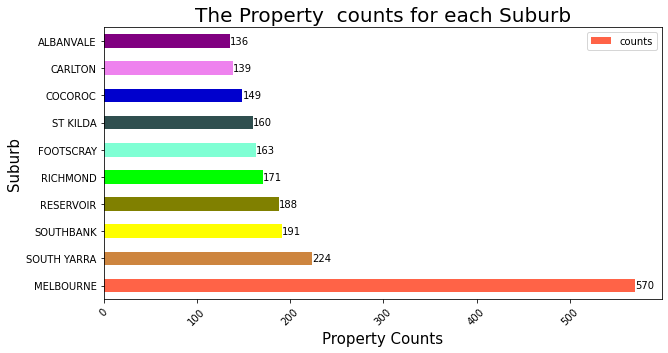

In [10]:
data = count_number.sort_values(by=['counts'], ascending=False).head(10)

#Bar char for visualize how many property are rent in suburb
fig = data.plot.barh(x="suburb", y="counts",figsize=(10,5),
                     color=['tomato', 'peru', 'yellow', 'olive', 'lime', 'aquamarine',
                            'darkslategray', 'mediumblue', 'violet', 'purple'])
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.xticks(rotation =45)
plt.ylabel('Suburb', fontsize=15)
plt.xlabel("Property Counts", fontsize=15)
plt.title("The Property  counts for each Suburb", size=20)
fig.bar_label(fig.containers[0])
#plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.5))
plt.show()
fig.figure.savefig('../plots/property_count.png')

In [11]:
mean_suburb = property_df.groupby('suburb').agg('mean')[['rent_weekly']].reset_index()
mean_suburb

,suburb,rent_weekly
0,ABBOTSFORD,571.875000
1,ABERFELDIE,490.454545
2,ADAMS ESTATE,470.833333
3,ADDINGTON,388.750000
4,ADELAIDE LEAD,380.000000
...,...,...
565,YARRAGON,420.000000
566,YARRAM,585.000000
567,YARRAVILLE,437.907692
568,YARRAWONGA,386.562500


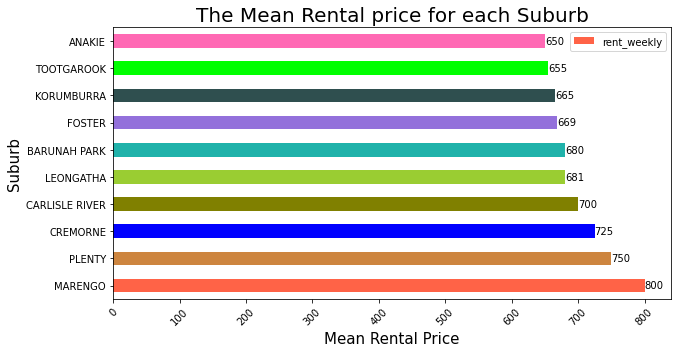

In [12]:
data = mean_suburb.sort_values(by=['rent_weekly'], ascending=False).head(10)

#Bar char for visualize how many property are rent in suburb
fig = data.plot.barh(x="suburb", y="rent_weekly",figsize=(10,5),
                     color=["tomato","peru","blue","olive","yellowgreen","lightseagreen","mediumpurple","darkslategray","lime","hotpink","maroon",'orange', 'indigo','gold','black'])
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.xticks(rotation =45)
plt.ylabel('Suburb', fontsize=15)
plt.xlabel("Mean Rental Price", fontsize=15)
plt.title("The Mean Rental price for each Suburb", size=20)
fig.bar_label(fig.containers[0])
#plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.5))
plt.show()
fig.figure.savefig('../plots/suburb_mean_desc.png')

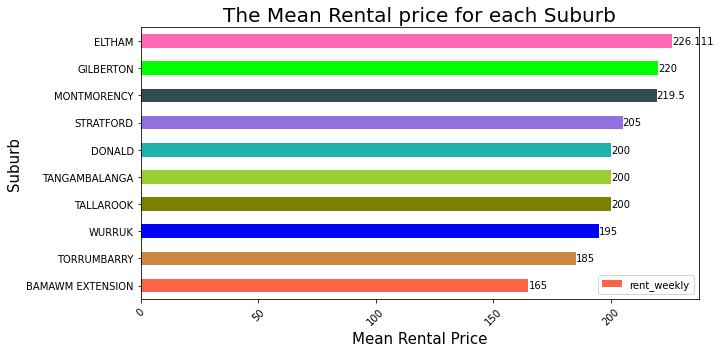

In [13]:
data = mean_suburb.sort_values(by=['rent_weekly'], ascending=True).head(10)

#Bar char for visualize how many property are rent in suburb
fig = data.plot.barh(x="suburb", y="rent_weekly",figsize=(10,5),
                     color=["tomato","peru","blue","olive","yellowgreen","lightseagreen","mediumpurple","darkslategray","lime","hotpink","maroon",'orange', 'indigo','gold','black'])
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.xticks(rotation =45)
plt.ylabel('Suburb', fontsize=15)
plt.xlabel("Mean Rental Price", fontsize=15)
plt.title("The Mean Rental price for each Suburb", size=20)
fig.bar_label(fig.containers[0])
#plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.5))
plt.show()
fig.figure.savefig('../plots/suburb_mean_asce.png')

In [14]:
property_df['type']= property_df['type'].replace('Townhouse','House')

In [15]:
apa = property_df[property_df['type'] == 'Apartment / Unit / Flat / Penhouse']
house = property_df[property_df['type'] == 'House']

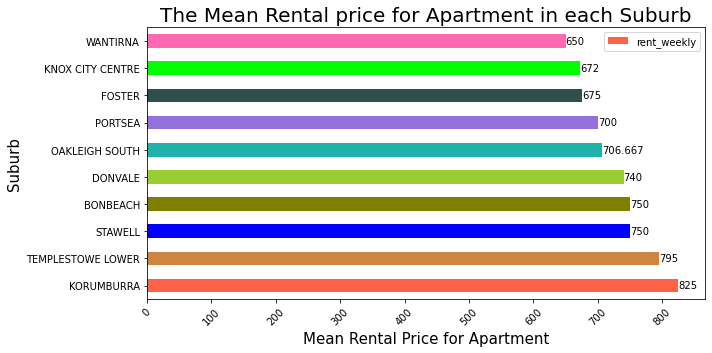

In [16]:
mean_suburb = apa.groupby('suburb').agg('mean')[['rent_weekly']].reset_index()
data = mean_suburb.sort_values(by=['rent_weekly'], ascending=False).head(10)

#Bar char for visualize how many property are rent in suburb
fig = data.plot.barh(x="suburb", y="rent_weekly",figsize=(10,5),
                     color=["tomato","peru","blue","olive","yellowgreen","lightseagreen","mediumpurple","darkslategray","lime","hotpink","maroon",'orange', 'indigo','gold','black'])
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.xticks(rotation =45)
plt.ylabel('Suburb', fontsize=15)
plt.xlabel("Mean Rental Price for Apartment", fontsize=15)
plt.title("The Mean Rental price for Apartment in each Suburb", size=20)
fig.bar_label(fig.containers[0])
#plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.5))
plt.show()
fig.figure.savefig('../plots/apa_suburb_mean_desc.png')

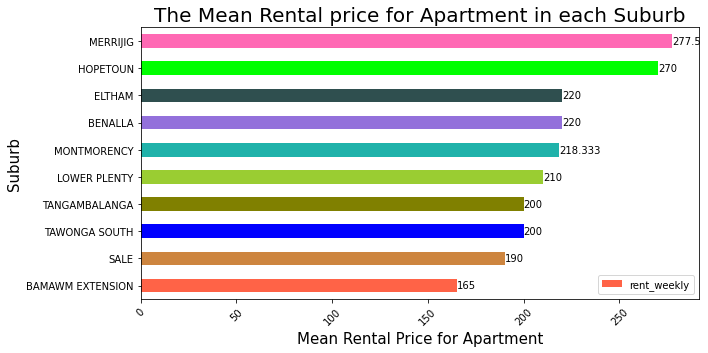

In [17]:
mean_suburb = apa.groupby('suburb').agg('mean')[['rent_weekly']].reset_index()
data = mean_suburb.sort_values(by=['rent_weekly'], ascending=True).head(10)

#Bar char for visualize how many property are rent in suburb
fig = data.plot.barh(x="suburb", y="rent_weekly",figsize=(10,5),
                     color=["tomato","peru","blue","olive","yellowgreen","lightseagreen","mediumpurple","darkslategray","lime","hotpink","maroon",'orange', 'indigo','gold','black'])
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.xticks(rotation =45)
plt.ylabel('Suburb', fontsize=15)
plt.xlabel("Mean Rental Price for Apartment", fontsize=15)
plt.title("The Mean Rental price for Apartment in each Suburb", size=20)
fig.bar_label(fig.containers[0])
#plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.5))
plt.show()
fig.figure.savefig('../plots/apa_suburb_mean_asce.png')

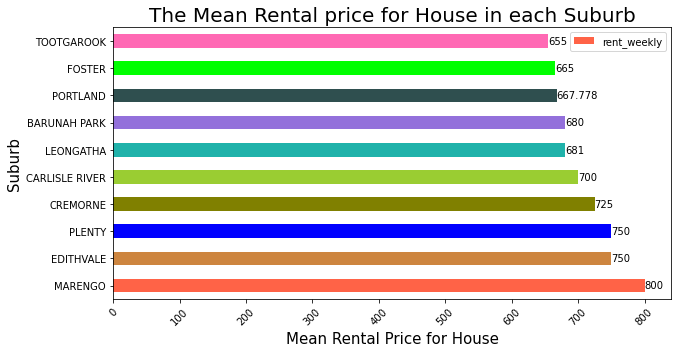

In [18]:
mean_suburb = house.groupby('suburb').agg('mean')[['rent_weekly']].reset_index()
data = mean_suburb.sort_values(by=['rent_weekly'], ascending=False).head(10)

#Bar char for visualize how many property are rent in suburb
fig = data.plot.barh(x="suburb", y="rent_weekly",figsize=(10,5),
                     color=["tomato","peru","blue","olive","yellowgreen","lightseagreen","mediumpurple","darkslategray","lime","hotpink","maroon",'orange', 'indigo','gold','black'])
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.xticks(rotation =45)
plt.ylabel('Suburb', fontsize=15)
plt.xlabel("Mean Rental Price for House", fontsize=15)
plt.title("The Mean Rental price for House in each Suburb", size=20)
fig.bar_label(fig.containers[0])
#plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.5))
plt.show()
fig.figure.savefig('../plots/house_suburb_mean_desc.png')

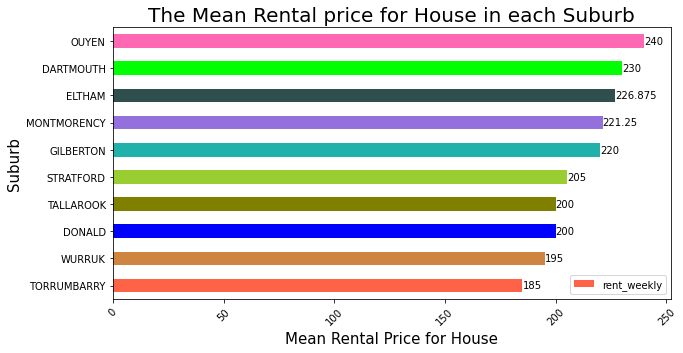

In [19]:
mean_suburb = house.groupby('suburb').agg('mean')[['rent_weekly']].reset_index()
data = mean_suburb.sort_values(by=['rent_weekly'], ascending=True).head(10)

#Bar char for visualize how many property are rent in suburb
fig = data.plot.barh(x="suburb", y="rent_weekly",figsize=(10,5),
                     color=["tomato","peru","blue","olive","yellowgreen","lightseagreen","mediumpurple","darkslategray","lime","hotpink","maroon",'orange', 'indigo','gold','black'])
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.xticks(rotation =45)
plt.ylabel('Suburb', fontsize=15)
plt.xlabel("Mean Rental Price for House", fontsize=15)
plt.title("The Mean Rental price for House in each Suburb", size=20)
fig.bar_label(fig.containers[0])
#plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.5))
plt.show()
fig.figure.savefig('../plots/house_suburb_mean_asce.png')

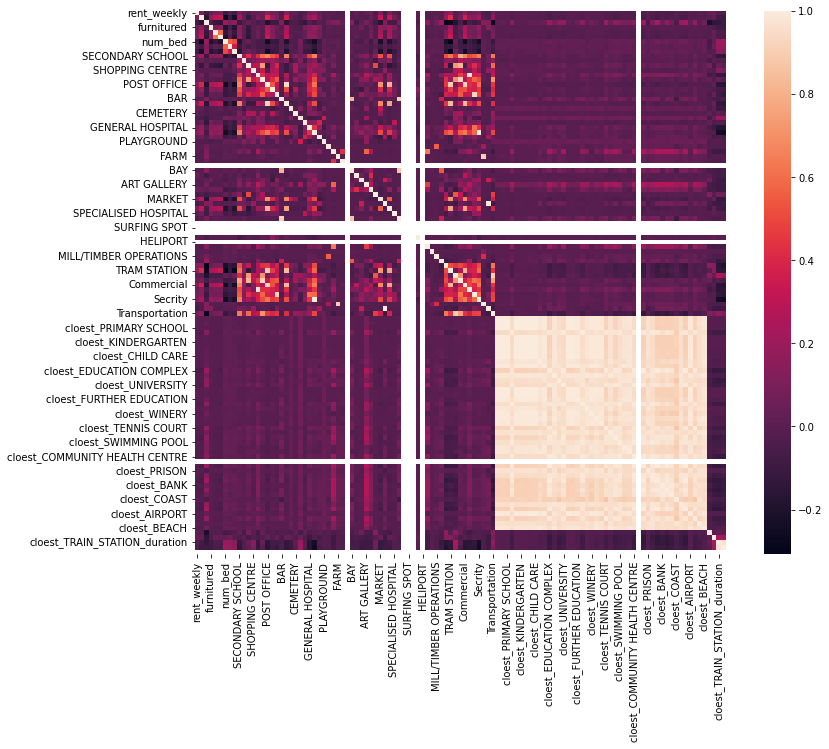

In [20]:
# Pearson correlation
fig, ax = plt.subplots(figsize = (12,10))
fig = sns.heatmap(property_df.corr())
fig.figure.savefig('../plots/heatmap.png',bbox_inches = 'tight')

In [21]:
property_df.corr().abs().iloc[0].to_frame().sort_values(by=['rent_weekly'],ascending=False).head(20)

,rent_weekly
rent_weekly,1.000000
TRAM STATION,0.174567
Commercial,0.156781
POST OFFICE,0.147616
SPORTS COMPLEX,0.133844
MARKET,0.123225
Secrity,0.117222
POLICE STATION,0.117222
TRAIN STATION,0.113993
gym,0.109401


## Young Adulthood

In [22]:
property_df['livable'] = property_df['Commercial']*0.3 + property_df['UNIVERSITY']*0.3 + property_df['TRAIN STATION']*0.05 + property_df['BUS']*0.05+ property_df['TRAM STATION']*0.1+ property_df['Secrity']*0.05 + property_df['Medication']*0.05 + property_df['Environment']*0.1
property_df = property_df.sort_values(by=['livable'], ascending=False)
property_df.head(3)

,address,rent_weekly,floor,suburb,postcode,type,furnitured,pool,gym,num_bed,...,cloest_IRON ORE PROCESSOR,cloest_MILL/TIMBER OPERATIONS,cloest_BEACH,cloest_TRAM STATION,cloest_BUS,cloest_TRAIN_STATION,cloest_TRAIN_STATION_duration,cloest_TRAIN_STATION_distance,counts,livable
0,1414/218-228 A'Beckett Street Melbourne VIC 3000,400,14,MELBOURNE,3000,Apartment / Unit / Flat / Penhouse,0,0,0,1,...,58968.064246,63924.811459,4924.342233,122.485883,37.427155,Flagstaff Railway Station (Melbourne City),41.4,282.0,1,22.3
383,3703/60 A'Beckett Street Melbourne VIC 3000,550,37,MELBOURNE,3000,Apartment / Unit / Flat / Penhouse,0,1,1,2,...,59404.476529,63639.666859,5352.621694,163.160144,285.314983,Melbourne Central Railway Station (Melbourne C...,54.7,378.7,1,22.3
377,506/139 Bourke Street Melbourne VIC 3000,550,5,MELBOURNE,3000,Apartment / Unit / Flat / Penhouse,0,0,0,1,...,59670.285940,63877.869915,5630.899724,30.014465,255.899582,Parliament Railway Station (Melbourne City),122.8,781.8,1,22.3


In [23]:
livable = property_df[['suburb','livable','UNIVERSITY', 'Commercial', 'Environment', 'Medication',
                       'Secrity', 'Transportation','BUS','TRAM STATION','TRAIN STATION']]
livable = livable.drop_duplicates()
livable = livable.reset_index(drop = True)
livable.to_csv('../data/curated/livable_youth.csv',index=False)
livable.head(15)

,suburb,livable,UNIVERSITY,Commercial,Environment,Medication,Secrity,Transportation,BUS,TRAM STATION,TRAIN STATION
0,MELBOURNE,22.30,0.0,14.0,23.0,3.0,2.0,184.0,54.0,127.0,3.0
1,RESERVOIR,17.75,0.0,1.0,9.0,2.0,1.0,317.0,302.0,11.0,4.0
2,FRANKSTON,14.40,0.0,3.0,24.0,4.0,1.0,217.0,215.0,0.0,2.0
3,PRESTON,14.20,0.0,4.0,4.0,3.0,2.0,207.0,165.0,40.0,2.0
4,WERRIBEE,14.10,1.0,1.0,18.0,4.0,1.0,229.0,227.0,0.0,2.0
5,CAMBERWELL,13.65,0.0,2.0,14.0,5.0,1.0,145.0,58.0,82.0,5.0
6,SUNBURY,13.50,0.0,2.0,14.0,1.0,1.0,228.0,227.0,0.0,1.0
7,BERWICK,13.10,0.0,2.0,18.0,3.0,1.0,210.0,209.0,0.0,1.0
8,MORNINGTON,12.20,0.0,2.0,62.0,1.0,1.0,106.0,106.0,0.0,0.0
9,COBURG,12.00,0.0,2.0,22.0,4.0,1.0,143.0,105.0,36.0,2.0


In [24]:
suburb_lis = livable['suburb'].to_list()[:15]

mean_rent = rent.groupby('suburb').agg('mean').reset_index().copy()
mean_rent = mean_rent[['suburb', 'current_rent_weekly', 'Dec_2022', 'Mar_2023','Jun_2023', 'Sep_2023', 'Dec_2023', 'Mar_2024', 'Jun_2024', 'Sep_2024','Dec_2024', 'Mar_2025', 'Jun_2025', 'Sep_2025', 'Dec_2025', 'Mar_2026','Jun_2026', 'Sep_2026', 'Dec_2026', 'Mar_2027', 'Jun_2027', 'Sep_2027','Dec_2027']]
mean_rent.columns = ['suburb', 'Sep_2022', 'Dec_2022', 'Mar_2023','Jun_2023', 'Sep_2023', 'Dec_2023', 'Mar_2024', 'Jun_2024', 'Sep_2024','Dec_2024', 'Mar_2025', 'Jun_2025', 'Sep_2025', 'Dec_2025', 'Mar_2026','Jun_2026', 'Sep_2026', 'Dec_2026', 'Mar_2027', 'Jun_2027', 'Sep_2027','Dec_2027']


median_rent = rent.groupby('suburb').agg('median').reset_index().copy()
median_rent = median_rent[['suburb', 'current_rent_weekly', 'Dec_2022', 'Mar_2023','Jun_2023', 'Sep_2023', 'Dec_2023', 'Mar_2024', 'Jun_2024', 'Sep_2024','Dec_2024', 'Mar_2025', 'Jun_2025', 'Sep_2025', 'Dec_2025', 'Mar_2026','Jun_2026', 'Sep_2026', 'Dec_2026', 'Mar_2027', 'Jun_2027', 'Sep_2027','Dec_2027']]
median_rent.columns = ['suburb', 'Sep_2022', 'Dec_2022', 'Mar_2023','Jun_2023', 'Sep_2023', 'Dec_2023', 'Mar_2024', 'Jun_2024', 'Sep_2024','Dec_2024', 'Mar_2025', 'Jun_2025', 'Sep_2025', 'Dec_2025', 'Mar_2026','Jun_2026', 'Sep_2026', 'Dec_2026', 'Mar_2027', 'Jun_2027', 'Sep_2027','Dec_2027']

rental = rental[['suburb','Mar_2000','Sep_2000','Sep_2001','Sep_2002','Sep_2003','Sep_2004','Sep_2005','Sep_2006','Sep_2007', 'Sep_2008','Sep_2009','Sep_2010', 'Sep_2011', 'Sep_2012', 'Sep_2013', 'Sep_2014', 'Sep_2015','Sep_2016','Sep_2017','Sep_2018','Sep_2019','Sep_2020','Sep_2021','Sep_2022','Sep_2023','Sep_2024','Sep_2025', 'Dec_2025']]

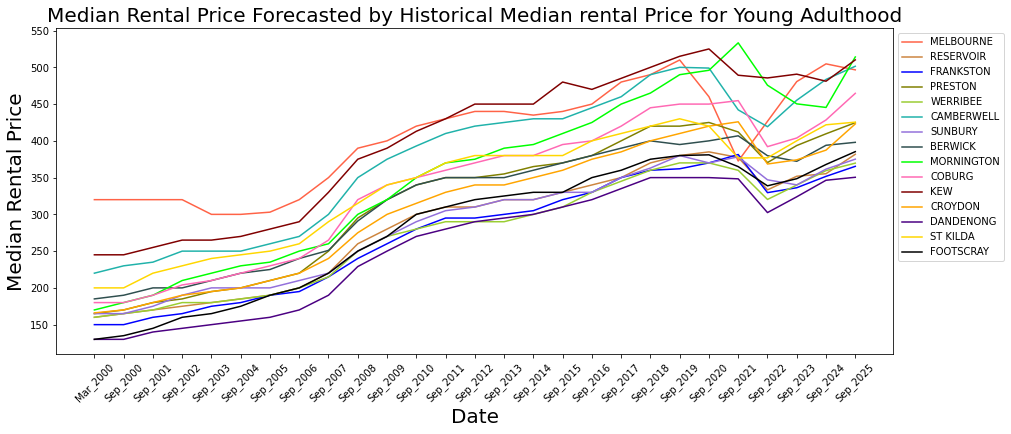

In [25]:
#line plot for visualize 
fig, ax = plt.subplots(figsize = (15,6))
plt.xlabel('Date', fontsize=20)
plt.ylabel('Median Rental Price', fontsize=20)
plt.title('Median Rental Price Forecasted by Historical Median rental Price for Young Adulthood', fontsize=20)

plt.xticks(rotation = 45)
colors=["tomato","peru","blue","olive","yellowgreen","lightseagreen","mediumpurple","darkslategray","lime","hotpink","maroon",'orange', 'indigo','gold','black']
i = 0
for suburb in suburb_lis:
    if rental[rental['suburb'] == suburb].shape[0] > 0:
        df = rental[rental['suburb'] == suburb].copy().transpose().reset_index()
        df = df.drop([0])
        df = df.drop([df.shape[0]])
        df.columns =['Date', suburb]
        #df['Date'] = df['Date'].str.slice(start=13)
        ax.plot(df['Date'], df[suburb], color = colors[i],linestyle = 'solid', label = suburb)
        i+=1

#ax.axvline(x='Sep_2022', color='r', linestyle='--', label = 'Jun_2021')
plt.legend(bbox_to_anchor=(1.0, 1.0))
fig.figure.savefig('../plots/rental.png')

In [26]:
mean_suburb = property_df.groupby('suburb').agg('mean')[['rent_weekly']].reset_index()
for suburb in list(mean_suburb['suburb'].unique()):
    if suburb not in suburb_lis:
        mean_suburb = mean_suburb[mean_suburb['suburb'] != suburb]
mean_suburb = mean_suburb.sort_values(by=['rent_weekly'], ascending=False)

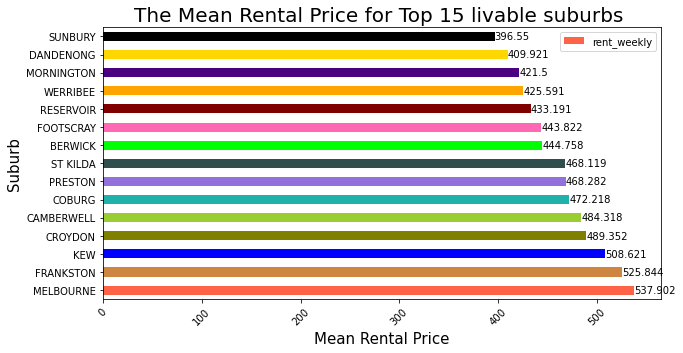

In [27]:
#Bar char for visualize how many property are rent in suburb
fig = mean_suburb.plot.barh(x="suburb", y="rent_weekly",figsize=(10,5),
                     color=["tomato","peru","blue","olive","yellowgreen","lightseagreen","mediumpurple","darkslategray","lime","hotpink","maroon",'orange', 'indigo','gold','black'])
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.xticks(rotation =45)
plt.ylabel('Suburb', fontsize=15)
plt.xlabel("Mean Rental Price", fontsize=15)
plt.title("The Mean Rental Price for Top 15 livable suburbs ", size=20)
fig.bar_label(fig.containers[0])
#plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.5))
plt.show()
fig.figure.savefig('../plots/apa_suburb_mean_desc.png')

In [28]:
median_suburb = property_df.groupby('suburb').agg('median')[['rent_weekly']].reset_index()
for suburb in list(median_suburb['suburb'].unique()):
    if suburb not in suburb_lis:
        median_suburb = median_suburb[median_suburb['suburb'] != suburb]
median_suburb = median_suburb.sort_values(by=['rent_weekly'], ascending=False)

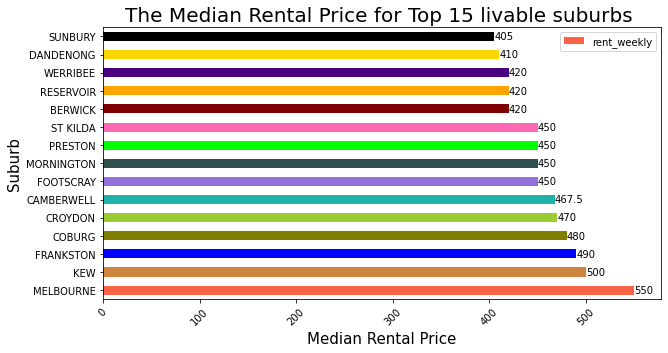

In [29]:
#Bar char for visualize how many property are rent in suburb
fig = median_suburb.plot.barh(x="suburb", y="rent_weekly",figsize=(10,5),
                     color=["tomato","peru","blue","olive","yellowgreen","lightseagreen","mediumpurple","darkslategray","lime","hotpink","maroon",'orange', 'indigo','gold','black'])
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.xticks(rotation =45)
plt.ylabel('Suburb', fontsize=15)
plt.xlabel("Median Rental Price", fontsize=15)
plt.title("The Median Rental Price for Top 15 livable suburbs ", size=20)
fig.bar_label(fig.containers[0])
#plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.5))
plt.show()
fig.figure.savefig('../plots/apa_suburb_mean_desc.png')

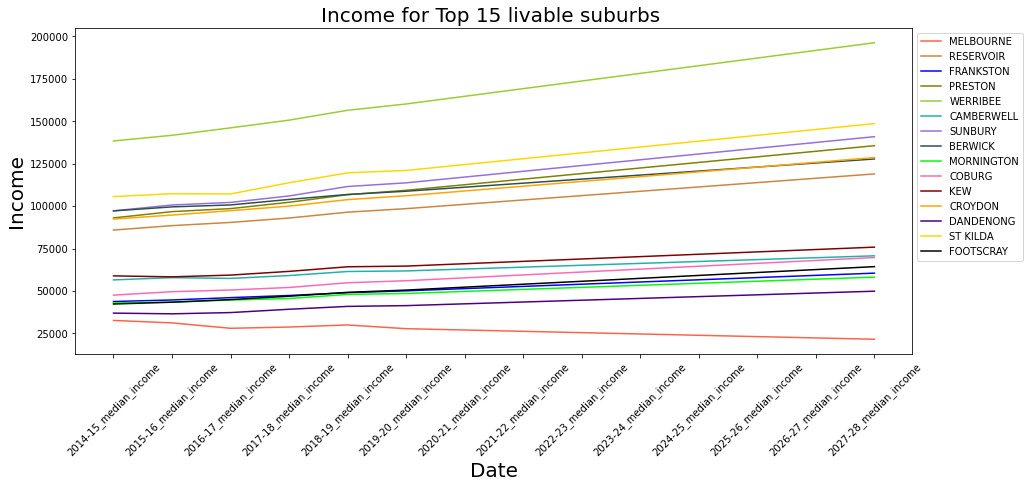

In [30]:
#line plot for visualize how many bikes are counted in each week day
fig, ax = plt.subplots(figsize = (15,6))
plt.xlabel('Date', fontsize=20)
plt.ylabel('Income', fontsize=20)
plt.title('Income for Top 15 livable suburbs ', fontsize=20)

plt.xticks(rotation = 45)
colors=["tomato","peru","blue","olive","yellowgreen","lightseagreen","mediumpurple","darkslategray","lime","hotpink","maroon",'orange', 'indigo','gold','black']
i = 0
for suburb in suburb_lis:
    if income[income['suburb'] == suburb].shape[0] > 0:
        df = income[income['suburb'] == suburb].copy().transpose().reset_index()
        df = df.drop([0])
        df = df.drop([df.shape[0]])
        df.columns =['Date', suburb]
        #df['Date'] = df['Date'].str.slice(start=13)
        ax.plot(df['Date'], df[suburb], color = colors[i],linestyle = 'solid', label = suburb)
        #ax.annotate(str(round(df[suburb].iloc[-1],2)),(df['Date'].iloc[-1],df[suburb].iloc[-1]),ha='left')
        i+=1

#ax.axvline(x='Sep_2022', color='r', linestyle='--', label = 'Jun_2021')
plt.legend(bbox_to_anchor=(1.0, 1.0))
fig.figure.savefig('../plots/rental.png')

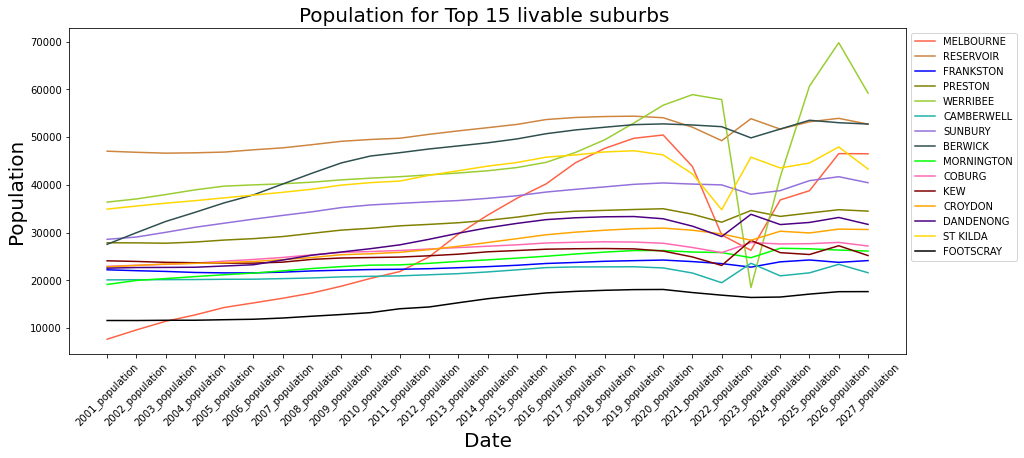

In [31]:
#line plot for visualize how many bikes are counted in each week day
fig, ax = plt.subplots(figsize = (15,6))
plt.xlabel('Date', fontsize=20)
plt.ylabel('Population', fontsize=20)
plt.title('Population for Top 15 livable suburbs ', fontsize=20)

plt.xticks(rotation = 45)
colors=["tomato","peru","blue","olive","yellowgreen","lightseagreen","mediumpurple","darkslategray","lime","hotpink","maroon",'orange', 'indigo','gold','black']
i = 0
for suburb in suburb_lis:
    if population[population['suburb'] == suburb].shape[0] > 0:
        df = population[population['suburb'] == suburb].copy().transpose().reset_index()
        df = df.drop([0])
        df = df.drop([df.shape[0]])
        df.columns =['Date', suburb]
        #df['Date'] = df['Date'].str.slice(start=13)
        ax.plot(df['Date'], df[suburb], color = colors[i],linestyle = 'solid', label = suburb)
        #ax.annotate(str(round(df[suburb].iloc[-1],2)),(df['Date'].iloc[-1],df[suburb].iloc[-1]),ha='left')
        i+=1

#ax.axvline(x='Sep_2022', color='r', linestyle='--', label = 'Jun_2021')
plt.legend(bbox_to_anchor=(1.0, 1.0))
fig.figure.savefig('../plots/rental.png')

In [32]:
affordable_dict = {'MELBOURNE': 'Melbourne', 'RESERVOIR' :'Darebin', 'FRANKSTON' :'Frankston',
                   'PRESTON':'Darebin','WERRIBEE':'Wyndham','CAMBERWELL':'Boroondara','SUNBURY':'Hume',
                   'BERWICK':'Casey','MORNINGTON':"Mornington Penin'a",'COBURG':'Darebin',
                   'KEW':'Boroondara','CROYDON':'Maroondah','DANDENONG':'Greater Dandenong',
                   'ST KILDA':'Port Phillip','FOOTSCRAY':'Maribyrnong'}

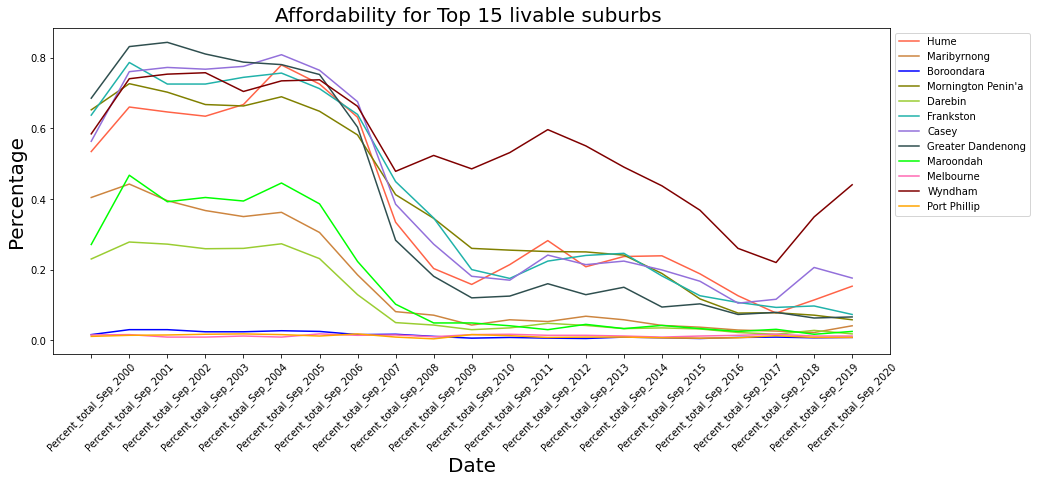

In [33]:
#line plot for visualize how many bikes are counted in each week day
fig, ax = plt.subplots(figsize = (15,6))
plt.xlabel('Date', fontsize=20)
plt.ylabel('Percentage', fontsize=20)
plt.title('Affordability for Top 15 livable suburbs ', fontsize=20)

plt.xticks(rotation = 45)
colors=["tomato","peru","blue","olive","yellowgreen","lightseagreen","mediumpurple","darkslategray","lime","hotpink","maroon",'orange', 'indigo','gold','black']
i = 0
LGA_lis = list(set(affordable_dict.values()))
for suburb in LGA_lis:
    if affordable[affordable['LGA'] == suburb].shape[0] > 0:
        df = affordable[affordable['LGA'] == suburb].copy().transpose().reset_index()
        df = df.drop([0])
        df = df.drop([df.shape[0]])
        df.columns =['Date', suburb]
        #df['Date'] = df['Date'].str.slice(start=13)
        ax.plot(df['Date'], df[suburb], color = colors[i],linestyle = 'solid', label = suburb)
        #ax.annotate(str(round(df[suburb].iloc[-1],2)),(df['Date'].iloc[-1],df[suburb].iloc[-1]),ha='left')
        i+=1

#ax.axvline(x='Sep_2022', color='r', linestyle='--', label = 'Jun_2021')
plt.legend(bbox_to_anchor=(1.0, 1.0))
fig.figure.savefig('../plots/rental.png')

## Middle Adulthood

In [34]:
property_df['livable'] = property_df['Commercial']*0.15 + property_df['BUS']*0.05 + property_df['TRAIN STATION']*0.1+ property_df['TRAM STATION']*0.05+ property_df['Secrity']*0.1 + property_df['Medication']*0.15 + property_df['Environment']*0.15 + property_df['Education']*0.3 - property_df['Prison']*0.2 - property_df['Industrial']*0.1
property_df = property_df.sort_values(by=['livable'], ascending=False)
property_df.head(10)

,address,rent_weekly,floor,suburb,postcode,type,furnitured,pool,gym,num_bed,...,cloest_IRON ORE PROCESSOR,cloest_MILL/TIMBER OPERATIONS,cloest_BEACH,cloest_TRAM STATION,cloest_BUS,cloest_TRAIN_STATION,cloest_TRAIN_STATION_duration,cloest_TRAIN_STATION_distance,counts,livable
5168,1 Gladstone Street Reservoir VIC 3073,370,1,RESERVOIR,3073,House,0,0,0,3,...,69616.363413,52114.972562,16498.689769,1900.560446,111.450929,Ruthven Railway Station (Reservoir),128.4,527.5,1,27.85
5191,10/71 Pine Street Reservoir VIC 3073,410,10,RESERVOIR,3073,Apartment / Unit / Flat / Penhouse,0,0,0,2,...,68363.572296,53047.559345,15390.105271,1363.332630,262.180924,Regent Railway Station (Reservoir),225.0,2054.9,1,27.85
5193,2/16 Mccomas Street Reservoir VIC 3073,500,2,RESERVOIR,3073,House,0,0,0,2,...,69320.857709,53597.063151,15662.674691,356.816956,138.138249,Reservoir Railway Station (Reservoir),280.8,2953.4,1,27.85
5194,8/9-11 Wilson Boulevard Reservoir VIC 3073,420,8,RESERVOIR,3073,Apartment / Unit / Flat / Penhouse,0,0,0,2,...,69023.341070,51948.180813,16372.903251,-1.000000,96.242365,Reservoir Railway Station (Reservoir),301.8,2511.1,1,27.85
5195,2/17 Best Street Reservoir VIC 3073,310,2,RESERVOIR,3073,Apartment / Unit / Flat / Penhouse,0,0,0,2,...,68640.093709,52616.854895,15777.282649,1789.947930,187.664000,Reservoir Railway Station (Reservoir),231.0,1725.3,1,27.85
5196,10/93-97 Edwardes Street Reservoir VIC 3073,470,10,RESERVOIR,3073,House,0,0,0,2,...,68714.953131,52800.710174,15688.494473,1652.994216,98.818989,Reservoir Railway Station (Reservoir),202.6,1266.9,1,27.85
5197,4/30 Kelsby Street Reservoir VIC 3073,330,4,RESERVOIR,3073,Apartment / Unit / Flat / Penhouse,1,0,0,2,...,68831.907336,52506.468348,15921.525060,1903.168655,77.060262,Reservoir Railway Station (Reservoir),269.8,1686.8,1,27.85
5198,3/46 Elsey Road Reservoir VIC 3073,570,3,RESERVOIR,3073,Apartment / Unit / Flat / Penhouse,0,0,0,2,...,70221.681566,51319.545606,17235.971903,2626.137703,177.495700,Ruthven Railway Station (Reservoir),102.6,427.4,1,27.85
5190,4/62 Andrews Avenue Reservoir VIC 3073,420,4,RESERVOIR,3073,House,0,0,0,3,...,69590.239646,53560.868109,15868.368742,534.896227,99.989740,Reservoir Railway Station (Reservoir),383.1,3493.0,1,27.85
5135,47 Dredge Street Reservoir VIC 3073,520,1,RESERVOIR,3073,House,0,0,0,3,...,69858.881001,50785.999567,17478.933363,-1.000000,200.503561,Keon Park Railway Station (Thomastown),264.0,2210.0,1,27.85


In [35]:
livable = property_df[['suburb','livable','Education', 'Commercial', 'Environment', 'Medication',
       'Secrity', 'Industrial', 'Prison', 'Transportation','BUS','TRAM STATION','TRAIN STATION']]
livable = livable.drop_duplicates()
livable = livable.reset_index(drop = True)
livable.to_csv('../data/curated/livable_middle.csv',index=False)
livable.head(20)

,suburb,livable,Education,Commercial,Environment,Medication,Secrity,Industrial,Prison,Transportation,BUS,TRAM STATION,TRAIN STATION
0,RESERVOIR,27.85,33.0,1.0,9.0,2.0,1.0,0.0,0.0,317.0,302.0,11.0,4.0
1,FRANKSTON,26.50,36.0,3.0,24.0,4.0,1.0,0.0,0.0,217.0,215.0,0.0,2.0
2,BERWICK,23.70,32.0,2.0,18.0,3.0,1.0,0.0,0.0,210.0,209.0,0.0,1.0
3,WERRIBEE,23.20,27.0,1.0,18.0,4.0,1.0,0.0,0.0,229.0,227.0,0.0,2.0
4,PRESTON,22.20,33.0,4.0,4.0,3.0,2.0,0.0,0.0,207.0,165.0,40.0,2.0
5,MELBOURNE,21.55,20.0,14.0,23.0,3.0,2.0,0.0,0.0,184.0,54.0,127.0,3.0
6,SUNBURY,21.00,23.0,2.0,14.0,1.0,1.0,0.0,0.0,228.0,227.0,0.0,1.0
7,MORNINGTON,20.85,19.0,2.0,62.0,1.0,1.0,0.0,0.0,106.0,106.0,0.0,0.0
8,CROYDON,19.35,25.0,2.0,24.0,1.0,1.0,0.0,0.0,153.0,152.0,0.0,1.0
9,COBURG,18.45,23.0,2.0,22.0,4.0,1.0,0.0,0.0,143.0,105.0,36.0,2.0


In [36]:
suburb_lis = livable['suburb'].to_list()[:15]

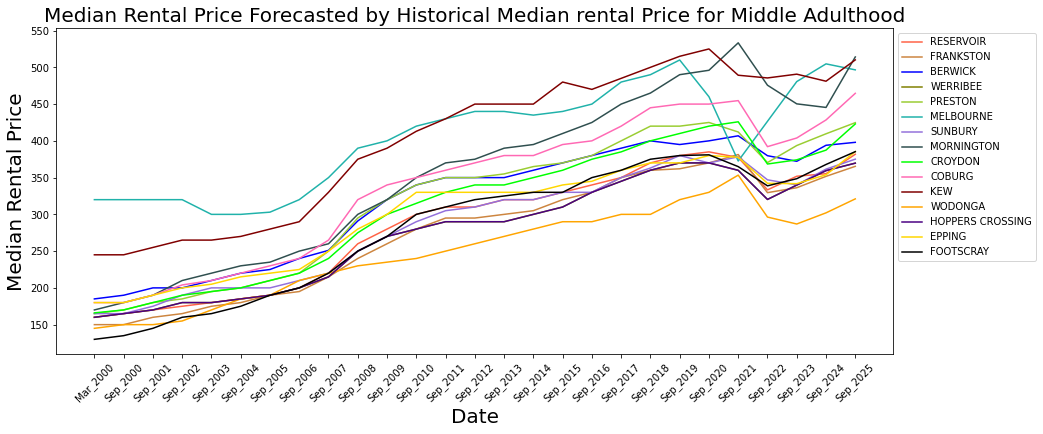

In [37]:
#line plot for visualize how many bikes are counted in each week day
fig, ax = plt.subplots(figsize = (15,6))
plt.xlabel('Date', fontsize=20)
plt.ylabel('Median Rental Price', fontsize=20)
plt.title('Median Rental Price Forecasted by Historical Median rental Price for Middle Adulthood', fontsize=20)

plt.xticks(rotation = 45)
colors=["tomato","peru","blue","olive","yellowgreen","lightseagreen","mediumpurple","darkslategray","lime","hotpink","maroon",'orange', 'indigo','gold','black']
i = 0
for suburb in suburb_lis:
    if rental[rental['suburb'] == suburb].shape[0] > 0:
        df = rental[rental['suburb'] == suburb].copy().transpose().reset_index()
        df = df.drop([0])
        df = df.drop([df.shape[0]])
        df.columns =['Date', suburb]
        #df['Date'] = df['Date'].str.slice(start=13)
        ax.plot(df['Date'], df[suburb], color = colors[i],linestyle = 'solid', label = suburb)
        i+=1

#ax.axvline(x='Sep_2022', color='r', linestyle='--', label = 'Jun_2021')
plt.legend(bbox_to_anchor=(1.0, 1.0))
fig.figure.savefig('../plots/rental.png')

In [38]:
median_suburb = property_df.groupby('suburb').agg('median')[['rent_weekly']].reset_index()
for suburb in list(median_suburb['suburb'].unique()):
    if suburb not in suburb_lis:
        median_suburb = median_suburb[median_suburb['suburb'] != suburb]
median_suburb = median_suburb.sort_values(by=['rent_weekly'], ascending=False)

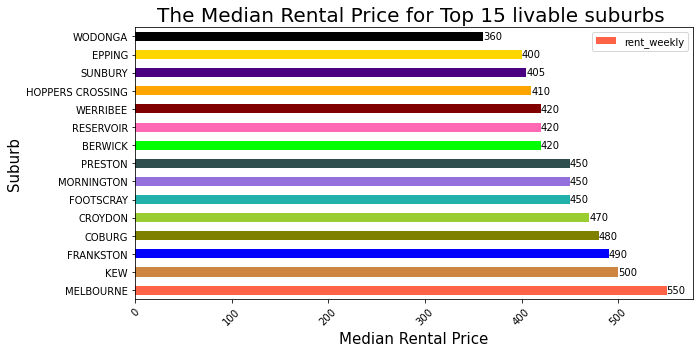

In [39]:
#Bar char for visualize how many property are rent in suburb
fig = median_suburb.plot.barh(x="suburb", y="rent_weekly",figsize=(10,5),
                     color=["tomato","peru","blue","olive","yellowgreen","lightseagreen","mediumpurple","darkslategray","lime","hotpink","maroon",'orange', 'indigo','gold','black'])
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.xticks(rotation =45)
plt.ylabel('Suburb', fontsize=15)
plt.xlabel("Median Rental Price", fontsize=15)
plt.title("The Median Rental Price for Top 15 livable suburbs ", size=20)
fig.bar_label(fig.containers[0])
#plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.5))
plt.show()
fig.figure.savefig('../plots/apa_suburb_mean_desc.png')

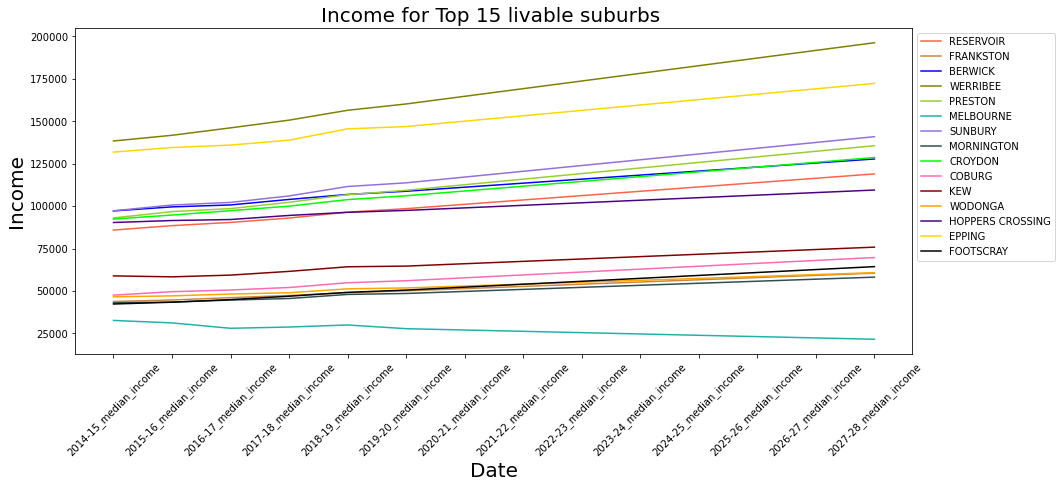

In [40]:
#line plot for visualize how many bikes are counted in each week day
fig, ax = plt.subplots(figsize = (15,6))
plt.xlabel('Date', fontsize=20)
plt.ylabel('Income', fontsize=20)
plt.title('Income for Top 15 livable suburbs ', fontsize=20)

plt.xticks(rotation = 45)
colors=["tomato","peru","blue","olive","yellowgreen","lightseagreen","mediumpurple","darkslategray","lime","hotpink","maroon",'orange', 'indigo','gold','black']
i = 0
for suburb in suburb_lis:
    if income[income['suburb'] == suburb].shape[0] > 0:
        df = income[income['suburb'] == suburb].copy().transpose().reset_index()
        df = df.drop([0])
        df = df.drop([df.shape[0]])
        df.columns =['Date', suburb]
        #df['Date'] = df['Date'].str.slice(start=13)
        ax.plot(df['Date'], df[suburb], color = colors[i],linestyle = 'solid', label = suburb)
        #ax.annotate(str(round(df[suburb].iloc[-1],2)),(df['Date'].iloc[-1],df[suburb].iloc[-1]),ha='left')
        i+=1

#ax.axvline(x='Sep_2022', color='r', linestyle='--', label = 'Jun_2021')
plt.legend(bbox_to_anchor=(1.0, 1.0))
fig.figure.savefig('../plots/rental.png')

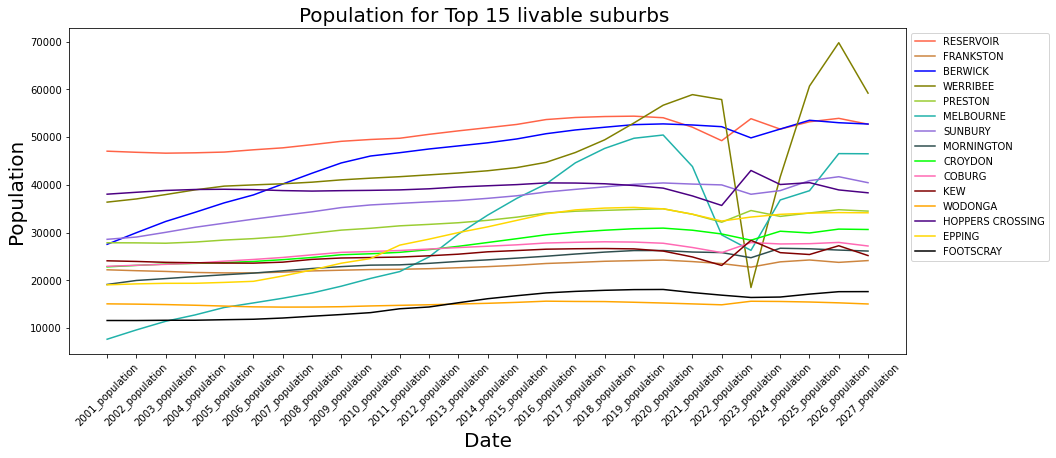

In [41]:
#line plot for visualize how many bikes are counted in each week day
fig, ax = plt.subplots(figsize = (15,6))
plt.xlabel('Date', fontsize=20)
plt.ylabel('Population', fontsize=20)
plt.title('Population for Top 15 livable suburbs ', fontsize=20)

plt.xticks(rotation = 45)
colors=["tomato","peru","blue","olive","yellowgreen","lightseagreen","mediumpurple","darkslategray","lime","hotpink","maroon",'orange', 'indigo','gold','black']
i = 0
for suburb in suburb_lis:
    if population[population['suburb'] == suburb].shape[0] > 0:
        df = population[population['suburb'] == suburb].copy().transpose().reset_index()
        df = df.drop([0])
        df = df.drop([df.shape[0]])
        df.columns =['Date', suburb]
        #df['Date'] = df['Date'].str.slice(start=13)
        ax.plot(df['Date'], df[suburb], color = colors[i],linestyle = 'solid', label = suburb)
        #ax.annotate(str(round(df[suburb].iloc[-1],2)),(df['Date'].iloc[-1],df[suburb].iloc[-1]),ha='left')
        i+=1

#ax.axvline(x='Sep_2022', color='r', linestyle='--', label = 'Jun_2021')
plt.legend(bbox_to_anchor=(1.0, 1.0))
fig.figure.savefig('../plots/rental.png')

In [42]:
affordable_dict = {'MELBOURNE': 'Melbourne', 'RESERVOIR' :'Darebin', 'FRANKSTON' :'Frankston',
                   'PRESTON':'Darebin','WERRIBEE':'Wyndham','WODONGA':'Wodonga','SUNBURY':'Hume',
                   'BERWICK':'Casey','MORNINGTON':"Mornington Penin'a",'COBURG':'Darebin',
                   'KEW':'Boroondara','CROYDON':'Maroondah','HOPPERS CROSSING':'Wyndham',
                   'EPPING':'Port Phillip','FOOTSCRAY':'Whittlesea'}

In [43]:
for i in affordable_dict.values():
    if i in list(affordable['LGA'].unique()):
        print('IN! ', i)
    else:
        print(i)

IN!  Melbourne
IN!  Darebin
IN!  Frankston
IN!  Darebin
IN!  Wyndham
IN!  Wodonga
IN!  Hume
IN!  Casey
IN!  Mornington Penin'a
IN!  Darebin
IN!  Boroondara
IN!  Maroondah
IN!  Wyndham
IN!  Port Phillip
IN!  Whittlesea


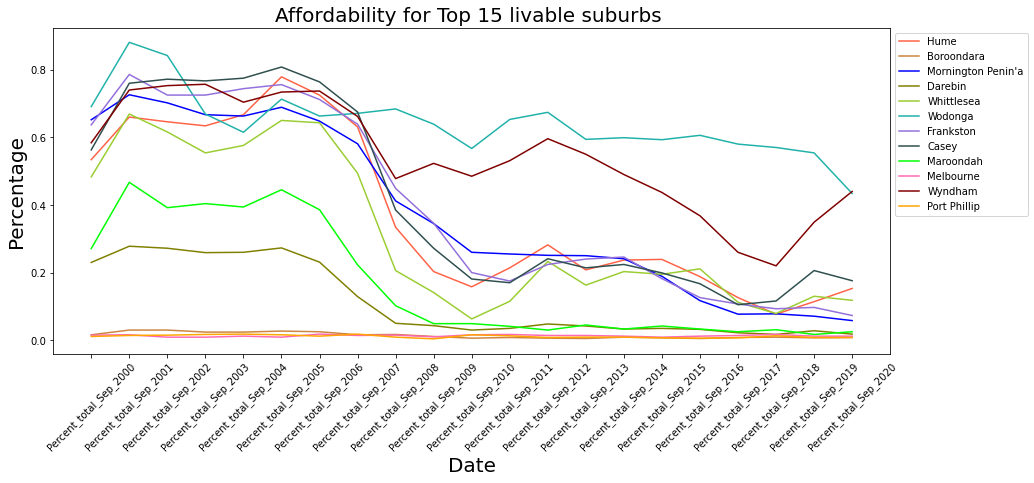

In [44]:
#line plot for visualize how many bikes are counted in each week day
fig, ax = plt.subplots(figsize = (15,6))
plt.xlabel('Date', fontsize=20)
plt.ylabel('Percentage', fontsize=20)
plt.title('Affordability for Top 15 livable suburbs ', fontsize=20)

plt.xticks(rotation = 45)
colors=["tomato","peru","blue","olive","yellowgreen","lightseagreen","mediumpurple","darkslategray","lime","hotpink","maroon",'orange', 'indigo','gold','black']
i = 0
LGA_lis = list(set(affordable_dict.values()))
for suburb in LGA_lis:
    if affordable[affordable['LGA'] == suburb].shape[0] > 0:
        df = affordable[affordable['LGA'] == suburb].copy().transpose().reset_index()
        df = df.drop([0])
        df = df.drop([df.shape[0]])
        df.columns =['Date', suburb]
        #df['Date'] = df['Date'].str.slice(start=13)
        ax.plot(df['Date'], df[suburb], color = colors[i],linestyle = 'solid', label = suburb)
        #ax.annotate(str(round(df[suburb].iloc[-1],2)),(df['Date'].iloc[-1],df[suburb].iloc[-1]),ha='left')
        i+=1

#ax.axvline(x='Sep_2022', color='r', linestyle='--', label = 'Jun_2021')
plt.legend(bbox_to_anchor=(1.0, 1.0))
fig.figure.savefig('../plots/rental.png')

## Late Adulthood

In [45]:
#property_df['livable'] = property_df['Commercial']*0.1 + property_df['Transportation']*0.2 + property_df['Secrity']*0.1 + property_df['Medication']*0.3 + property_df['Environment']*0.3 - property_df['Prison']*0.2 - property_df['Industrial']*0.1
property_df['livable'] = property_df['Commercial']*0.1 + property_df['BUS']*0.05 + property_df['TRAIN STATION']*0.1+ property_df['TRAM STATION']*0.05 + property_df['Secrity']*0.1 + property_df['Medication']*0.3 + property_df['Environment']*0.3 - property_df['Prison']*0.2 - property_df['Industrial']*0.1
property_df = property_df.sort_values(by=['livable'], ascending=False)
property_df.head(10)

,address,rent_weekly,floor,suburb,postcode,type,furnitured,pool,gym,num_bed,...,cloest_IRON ORE PROCESSOR,cloest_MILL/TIMBER OPERATIONS,cloest_BEACH,cloest_TRAM STATION,cloest_BUS,cloest_TRAIN_STATION,cloest_TRAIN_STATION_duration,cloest_TRAIN_STATION_distance,counts,livable
13047,1/16 Kent Street Mornington VIC 3931,450,1,MORNINGTON,3931,House,0,0,0,3,...,54870.197380,74444.738841,1039.755633,-1.0,196.660039,-1,-1.0,-1.0,1,24.5
13041,6/7 Cranswick Court Mornington VIC 3931,400,6,MORNINGTON,3931,Apartment / Unit / Flat / Penhouse,0,0,0,2,...,56401.285994,74051.416762,2378.624646,-1.0,623.971753,-1,-1.0,-1.0,1,24.5
13042,10/28 Lucerne Avenue Mornington VIC 3931,480,10,MORNINGTON,3931,Apartment / Unit / Flat / Penhouse,0,0,0,2,...,55561.276664,73554.121011,1292.588768,-1.0,202.690387,-1,-1.0,-1.0,1,24.5
13038,4 Lucerne Avenue Mornington VIC 3931,320,1,MORNINGTON,3931,House,0,0,0,3,...,55479.438471,73455.760505,1003.133261,-1.0,274.662898,-1,-1.0,-1.0,1,24.5
13043,5 Nunns Road Mornington VIC 3931,130,1,MORNINGTON,3931,House,0,0,0,2,...,54214.579533,74982.467627,415.079666,-1.0,58.979028,-1,-1.0,-1.0,1,24.5
13044,6/94 Beleura Hill Road Mornington VIC 3931,450,6,MORNINGTON,3931,Apartment / Unit / Flat / Penhouse,0,0,0,2,...,55624.625839,73340.936059,1109.745133,-1.0,163.265415,-1,-1.0,-1.0,1,24.5
13045,3/38 Amelia Ave Mornington VIC 3931,450,3,MORNINGTON,3931,House,0,0,0,4,...,55792.233489,73212.608129,1247.457148,-1.0,114.002505,-1,-1.0,-1.0,1,24.5
13046,2/13 King Georges Ave Mornington VIC 3931,500,1,MORNINGTON,3931,House,0,0,0,2,...,53790.165583,75499.855101,498.775412,-1.0,152.804092,-1,-1.0,-1.0,1,24.5
13039,15 Inglis Street Mornington VIC 3931,595,1,MORNINGTON,3931,House,0,0,0,3,...,55755.011216,72991.126874,936.349801,-1.0,294.735558,-1,-1.0,-1.0,1,24.5
13040,2/7 Hargreaves Street Mornington VIC 3931,440,1,MORNINGTON,3931,House,0,0,0,3,...,53909.313004,75276.576928,280.448997,-1.0,87.563428,-1,-1.0,-1.0,1,24.5


In [46]:
livable = property_df[['suburb','livable', 'Commercial', 'Environment', 'Medication',
       'Secrity', 'Industrial', 'Prison', 'Transportation','BUS','TRAM STATION','TRAIN STATION']]
livable = livable.drop_duplicates()
livable = livable.reset_index(drop = True)
livable.to_csv('../data/curated/livable_late.csv',index=False)
livable.head(20)

,suburb,livable,Commercial,Environment,Medication,Secrity,Industrial,Prison,Transportation,BUS,TRAM STATION,TRAIN STATION
0,MORNINGTON,24.50,2.0,62.0,1.0,1.0,0.0,0.0,106.0,106.0,0.0,0.0
1,WODONGA,22.10,1.0,70.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,FRANKSTON,19.75,3.0,24.0,4.0,1.0,0.0,0.0,217.0,215.0,0.0,2.0
3,RESERVOIR,19.55,1.0,9.0,2.0,1.0,0.0,0.0,317.0,302.0,11.0,4.0
4,MELBOURNE,18.75,14.0,23.0,3.0,2.0,0.0,0.0,184.0,54.0,127.0,3.0
5,WERRIBEE,18.35,1.0,18.0,4.0,1.0,0.0,0.0,229.0,227.0,0.0,2.0
6,BERWICK,17.15,2.0,18.0,3.0,1.0,0.0,0.0,210.0,209.0,0.0,1.0
7,MOUNT MARTHA,16.65,1.0,42.0,0.0,0.0,0.0,0.0,79.0,79.0,0.0,0.0
8,SUNBURY,16.25,2.0,14.0,1.0,1.0,0.0,0.0,228.0,227.0,0.0,1.0
9,CROYDON,15.50,2.0,24.0,1.0,1.0,0.0,0.0,153.0,152.0,0.0,1.0


In [47]:
suburb_lis = livable['suburb'].to_list()[:15]

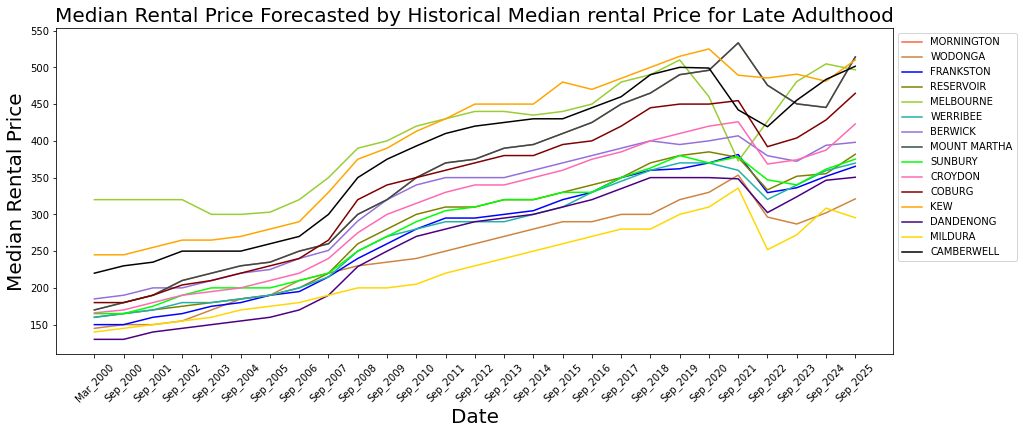

In [48]:
#line plot for visualize how many bikes are counted in each week day
fig, ax = plt.subplots(figsize = (15,6))
plt.xlabel('Date', fontsize=20)
plt.ylabel('Median Rental Price', fontsize=20)
plt.title('Median Rental Price Forecasted by Historical Median rental Price for Late Adulthood', fontsize=20)

plt.xticks(rotation = 45)
colors=["tomato","peru","blue","olive","yellowgreen","lightseagreen","mediumpurple","darkslategray","lime","hotpink","maroon",'orange', 'indigo','gold','black']
i = 0
for suburb in suburb_lis:
    if rental[rental['suburb'] == suburb].shape[0] > 0:
        df = rental[rental['suburb'] == suburb].copy().transpose().reset_index()
        df = df.drop([0])
        df = df.drop([df.shape[0]])
        df.columns =['Date', suburb]
        #df['Date'] = df['Date'].str.slice(start=13)
        ax.plot(df['Date'], df[suburb], color = colors[i],linestyle = 'solid', label = suburb)
        i+=1

#ax.axvline(x='Sep_2022', color='r', linestyle='--', label = 'Jun_2021')
plt.legend(bbox_to_anchor=(1.0, 1.0))
fig.figure.savefig('../plots/rental.png')

In [49]:
median_suburb = property_df.groupby('suburb').agg('median')[['rent_weekly']].reset_index()
for suburb in list(median_suburb['suburb'].unique()):
    if suburb not in suburb_lis:
        median_suburb = median_suburb[median_suburb['suburb'] != suburb]
median_suburb = median_suburb.sort_values(by=['rent_weekly'], ascending=False)

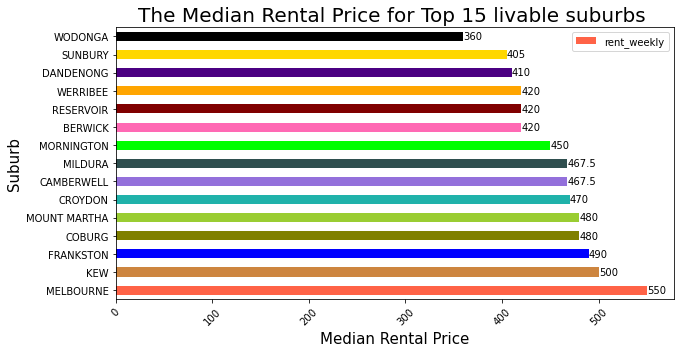

In [50]:
#Bar char for visualize how many property are rent in suburb
fig = median_suburb.plot.barh(x="suburb", y="rent_weekly",figsize=(10,5),
                     color=["tomato","peru","blue","olive","yellowgreen","lightseagreen","mediumpurple","darkslategray","lime","hotpink","maroon",'orange', 'indigo','gold','black'])
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.xticks(rotation =45)
plt.ylabel('Suburb', fontsize=15)
plt.xlabel("Median Rental Price", fontsize=15)
plt.title("The Median Rental Price for Top 15 livable suburbs ", size=20)
fig.bar_label(fig.containers[0])
#plt.legend(loc='upper left', bbox_to_anchor=(1.0, 0.5))
plt.show()
fig.figure.savefig('../plots/apa_suburb_mean_desc.png')

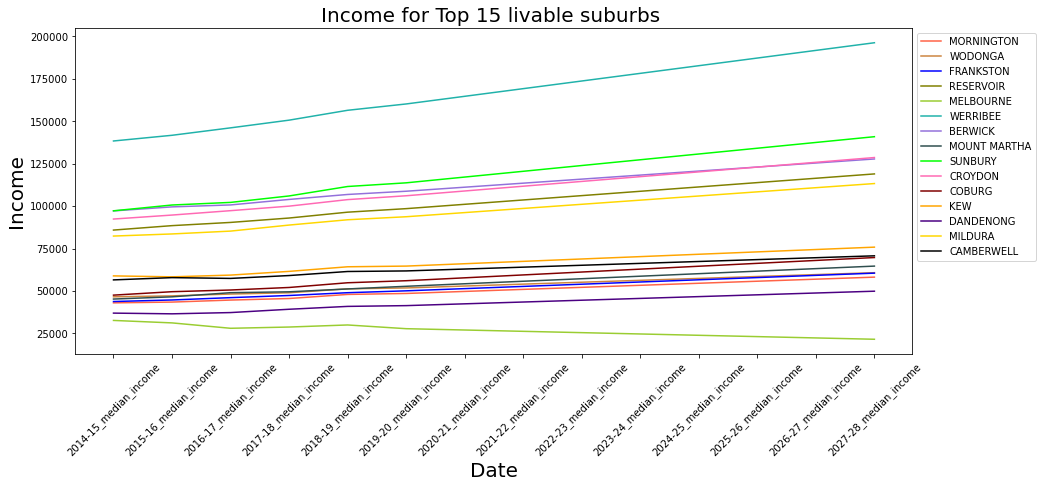

In [51]:
#line plot for visualize how many bikes are counted in each week day
fig, ax = plt.subplots(figsize = (15,6))
plt.xlabel('Date', fontsize=20)
plt.ylabel('Income', fontsize=20)
plt.title('Income for Top 15 livable suburbs ', fontsize=20)

plt.xticks(rotation = 45)
colors=["tomato","peru","blue","olive","yellowgreen","lightseagreen","mediumpurple","darkslategray","lime","hotpink","maroon",'orange', 'indigo','gold','black']
i = 0
for suburb in suburb_lis:
    if income[income['suburb'] == suburb].shape[0] > 0:
        df = income[income['suburb'] == suburb].copy().transpose().reset_index()
        df = df.drop([0])
        df = df.drop([df.shape[0]])
        df.columns =['Date', suburb]
        #df['Date'] = df['Date'].str.slice(start=13)
        ax.plot(df['Date'], df[suburb], color = colors[i],linestyle = 'solid', label = suburb)
        #ax.annotate(str(round(df[suburb].iloc[-1],2)),(df['Date'].iloc[-1],df[suburb].iloc[-1]),ha='left')
        i+=1

#ax.axvline(x='Sep_2022', color='r', linestyle='--', label = 'Jun_2021')
plt.legend(bbox_to_anchor=(1.0, 1.0))
fig.figure.savefig('../plots/rental.png')

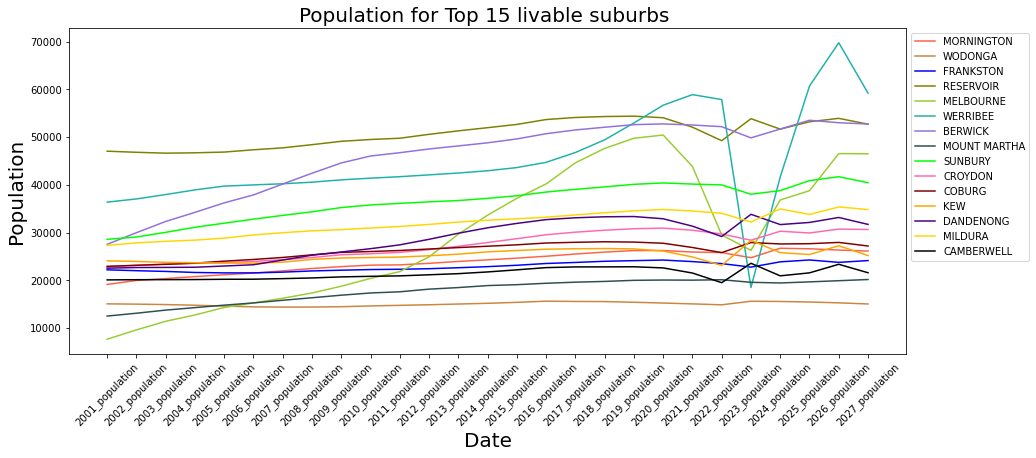

In [52]:
#line plot for visualize how many bikes are counted in each week day
fig, ax = plt.subplots(figsize = (15,6))
plt.xlabel('Date', fontsize=20)
plt.ylabel('Population', fontsize=20)
plt.title('Population for Top 15 livable suburbs ', fontsize=20)

plt.xticks(rotation = 45)
colors=["tomato","peru","blue","olive","yellowgreen","lightseagreen","mediumpurple","darkslategray","lime","hotpink","maroon",'orange', 'indigo','gold','black']
i = 0
for suburb in suburb_lis:
    if population[population['suburb'] == suburb].shape[0] > 0:
        df = population[population['suburb'] == suburb].copy().transpose().reset_index()
        df = df.drop([0])
        df = df.drop([df.shape[0]])
        df.columns =['Date', suburb]
        #df['Date'] = df['Date'].str.slice(start=13)
        ax.plot(df['Date'], df[suburb], color = colors[i],linestyle = 'solid', label = suburb)
        #ax.annotate(str(round(df[suburb].iloc[-1],2)),(df['Date'].iloc[-1],df[suburb].iloc[-1]),ha='left')
        i+=1

#ax.axvline(x='Sep_2022', color='r', linestyle='--', label = 'Jun_2021')
plt.legend(bbox_to_anchor=(1.0, 1.0))
fig.figure.savefig('../plots/rental.png')

In [53]:
affordable_dict = {'MELBOURNE': 'Melbourne', 'RESERVOIR' :'Darebin', 'FRANKSTON' :'Frankston',
                   'MOUNT MARTHA':"Mornington Penin'a",'WERRIBEE':'Wyndham','CAMBERWELL':'Boroondara',
                   'SUNBURY':'Hume','BERWICK':'Casey','MORNINGTON':"Mornington Penin'a",'COBURG':'Darebin',
                   'KEW':'Boroondara','CROYDON':'Maroondah','DANDENONG':'Greater Dandenong',
                   'MILDURA':'Mildura','FOOTSCRAY':'Maribyrnong'}

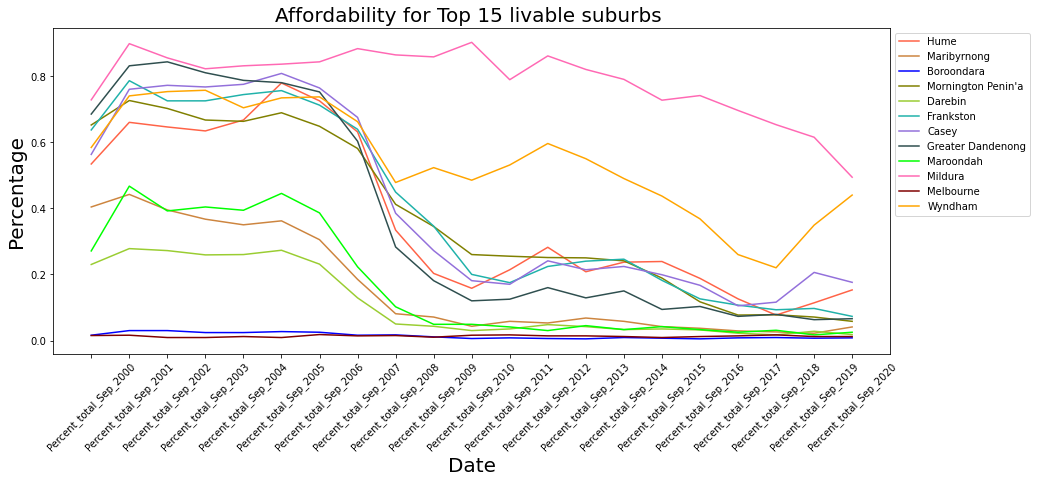

In [54]:
#line plot for visualize how many bikes are counted in each week day
fig, ax = plt.subplots(figsize = (15,6))
plt.xlabel('Date', fontsize=20)
plt.ylabel('Percentage', fontsize=20)
plt.title('Affordability for Top 15 livable suburbs ', fontsize=20)

plt.xticks(rotation = 45)
colors=["tomato","peru","blue","olive","yellowgreen","lightseagreen","mediumpurple","darkslategray","lime","hotpink","maroon",'orange', 'indigo','gold','black']
i = 0
LGA_lis = list(set(affordable_dict.values()))
for suburb in LGA_lis:
    if affordable[affordable['LGA'] == suburb].shape[0] > 0:
        df = affordable[affordable['LGA'] == suburb].copy().transpose().reset_index()
        df = df.drop([0])
        df = df.drop([df.shape[0]])
        df.columns =['Date', suburb]
        #df['Date'] = df['Date'].str.slice(start=13)
        ax.plot(df['Date'], df[suburb], color = colors[i],linestyle = 'solid', label = suburb)
        #ax.annotate(str(round(df[suburb].iloc[-1],2)),(df['Date'].iloc[-1],df[suburb].iloc[-1]),ha='left')
        i+=1

#ax.axvline(x='Sep_2022', color='r', linestyle='--', label = 'Jun_2021')
plt.legend(bbox_to_anchor=(1.0, 1.0))
fig.figure.savefig('../plots/rental.png')

## Growth Rate

In [55]:
rental['growth_rate_22-25'] = (rental['Sep_2025'] - rental['Sep_2022']) / rental['Sep_2022']
rental_top_10_growth = rental.sort_values(by=['growth_rate_22-25'], ascending=False).head(10)[['suburb','growth_rate_22-25']]
rental_top_10_growth.index = range(1, len(rental_top_10_growth)+1)
rental_top_10_growth.style.format({'growth_rate_22-25': '{:,.2%}'.format})

,suburb,growth_rate_22-25
1,WANGARATTA,34.28%
2,HASTINGS,29.11%
3,FLINDERS,29.11%
4,LARA,27.83%
5,CARLTON,23.70%
6,PARKVILLE,23.70%
7,HERNE HILL,21.71%
8,GEELONG WEST,21.71%
9,CAMBERWELL,19.61%
10,GLEN IRIS,19.61%


In [56]:
rental

,suburb,Mar_2000,Sep_2000,Sep_2001,Sep_2002,Sep_2003,Sep_2004,Sep_2005,Sep_2006,Sep_2007,...,Sep_2018,Sep_2019,Sep_2020,Sep_2021,Sep_2022,Sep_2023,Sep_2024,Sep_2025,Dec_2025,growth_rate_22-25
0,YARRAVILLE,175.0,180.0,190.0,200.0,210.0,220.0,230.0,240.0,275.0,...,465.0,490.0,490.0,479.598186,428.894562,425.079751,461.635137,476.888199,472.206287,0.111901
1,WODONGA,145.0,150.0,150.0,155.0,170.0,185.0,190.0,210.0,220.0,...,300.0,320.0,330.0,353.376955,296.323534,286.888707,302.067377,321.054446,328.045832,0.083459
2,WINDSOR,220.0,230.0,245.0,260.0,260.0,260.0,270.0,285.0,320.0,...,435.0,450.0,450.0,418.606680,403.053060,400.921754,425.953232,427.755669,438.240129,0.061289
3,WILLIAMSTOWN,240.0,240.0,260.0,265.0,265.0,270.0,275.0,295.0,330.0,...,510.0,510.0,520.0,508.011690,472.629426,498.504757,478.139881,524.798758,521.912354,0.110381
4,WHITTLESEA,150.0,155.0,165.0,180.0,200.0,210.0,213.0,240.0,250.0,...,375.0,380.0,390.0,389.088522,339.847202,344.234641,366.995362,391.382998,389.291592,0.151644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,ALTONA,165.0,170.0,175.0,185.0,190.0,200.0,210.0,220.0,248.0,...,400.0,400.0,400.0,398.485317,366.706809,378.197996,389.738146,413.716947,389.224616,0.128195
209,ALPHINGTON,150.0,150.0,165.0,180.0,190.0,195.0,200.0,210.0,240.0,...,410.0,450.0,420.0,396.619818,374.577626,375.453380,404.482597,425.230432,446.551272,0.135226
210,ALFREDTON,130.0,135.0,140.0,160.0,170.0,180.0,180.0,185.0,195.0,...,305.0,330.0,340.0,360.629499,292.042296,293.211758,282.587399,314.131175,336.300762,0.075636
211,ALBERT PARK,260.0,270.0,280.0,300.0,295.0,300.0,310.0,310.0,375.0,...,570.0,565.0,560.0,484.559770,484.141889,538.020772,549.641926,572.203898,549.904660,0.181893
